<a href="https://colab.research.google.com/github/ajayvallabh/GraphNeuralNetwork/blob/main/GAT_for_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
!mamba install -c conda-forge rdkit pandas numpy


Looking for: ['rdkit', 'pandas', 'numpy']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   2%
conda-forge/noarch    ⣾  [+] 0.3s
conda-forge/linux-64  15%
conda-forge/noarch    10%[+] 0.4s
conda-forge/linux-64  29%
conda-forge/noarch    30%[+] 0.5s
conda-forge/linux-64  41%
conda-forge/noarch    55%[+] 0.6s
conda-forge/linux-64  53%
conda-forge/noarch    80%[+] 0.7s
conda-forge/linux-64  60%
conda-forge/noarch    91%conda-forge/noarch                                
[+] 0.8s
conda-forge/linux-64  65%[+] 0.9s
conda-forge/linux-64  88%[+] 1.0s
conda-forge/linux-64 100%[+] 1.1s
conda-forge/linux-64 100%conda-forge/linux-64                              

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - rdkit
   - pandas
   - numpy
   - ca-certificates
   - certifi
   - openssl


  Package                          Version  

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch_geometric.data import Data
from rdkit.Chem import Crippen
import numpy as np

# Data Loading

In [ ]:
def preprocess_data(df):
      #df['SMILES'] = df['SMILES'].str.replace('[()=]', '', regex=True)
      df['charge'] = df.apply(lambda row: calculate_charge(row['pH'], row['pKa'], is_acid=True), axis=1)
      df['charge_product'] = (df['IEP'] - df['pH']) * df['charge']
      df['Init_conc'] = df['Init_conc']/df['Mw']
      df['group'] = df['ref_ID'].map(str) + df['PFAS']

      return df

def calculate_charge(pH, pKa, is_acid=True):
      ratio = 10 ** (pH - pKa)
      fraction_deprotonated = ratio / (1 + ratio)

      if is_acid:
          charge = -fraction_deprotonated
      else:
          charge = 1 - fraction_deprotonated

      return charge

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
path = '/gdrive/My Drive/Colab Notebooks/cleaned_afff_data.xlsx'
df = pd.read_excel(path)

df.columns = ['ID', 'Membrane', 'MWCO', 'IEP',
              'CA', 'PFAS', 'Mw', 'SMILES',
              'Size', 'log Kow', 'pKa', 'Init_conc',
              'IS', 'Pres', 'pH', 'Removal_rate', 'ref_ID', 'ref']

df = preprocess_data(df)
df = df.dropna(subset=['IEP'])
df.index = range(len(df))

input_vars = ['MWCO', 'CA', 'Size', 'log Kow', 'Init_conc', 'Pres', 'IS', 'charge_product']


In [ ]:
df

,ID,Membrane,MWCO,IEP,CA,PFAS,Mw,SMILES,Size,log Kow,...,Init_conc,IS,Pres,pH,Removal_rate,ref_ID,ref,charge,charge_product,group
0,2,NF90,118,3.28,52.9,PFPeA,264,C(=O)(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)[O-],4.015968,-0.52,...,1.946591,10.0,185.00,7.0,89.863274,1,exp,-1.0,3.719999,1PFPeA
1,3,NF90,118,3.28,52.9,PFBS,300,C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(C(F)(F)F)(F)F,3.992443,0.25,...,14.156750,10.0,185.00,7.0,98.819583,1,exp,-1.0,3.720000,1PFBS
2,4,NF90,118,3.28,52.9,PFHxA,314,C(=O)(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-],4.128813,0.18,...,7.246576,10.0,185.00,7.0,98.270808,1,exp,-1.0,3.719999,1PFHxA
3,5,NF90,118,3.28,52.9,PFPeS,350,C(C(C(F)(F)F)(F)F)(C(C(F)(F)S(=O)(=O)[O-])(F)F...,4.317291,0.95,...,9.523357,10.0,185.00,7.0,98.560089,1,exp,-1.0,3.720000,1PFPeS
4,6,NF90,118,3.28,52.9,PFHpA,364,C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(...,4.339435,0.88,...,1.991415,10.0,185.00,7.0,96.999199,1,exp,-1.0,3.719999,1PFHpA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,530,ESNA,250,3.10,47.3,PFOS,500,C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...,5.089106,3.05,...,200.000000,12.0,116.03,7.0,97.940000,22-4,Study on the effects of cations and anions on ...,-1.0,3.900000,22-4PFOS
528,531,ESNA,250,3.10,47.3,PFOS,500,C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...,5.089106,3.05,...,200.000000,0.3,116.03,7.0,96.090000,22-5,Study on the effects of cations and anions on ...,-1.0,3.900000,22-5PFOS
529,532,ESNA,250,3.10,47.3,PFOS,500,C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...,5.089106,3.05,...,200.000000,6.0,116.03,7.0,97.600000,22-6,Study on the effects of cations and anions on ...,-1.0,3.900000,22-6PFOS
530,533,ESNA,250,3.10,47.3,PFOS,500,C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...,5.089106,3.05,...,200.000000,0.6,116.03,7.0,96.330000,22-7,Study on the effects of cations and anions on ...,-1.0,3.900000,22-7PFOS


In [ ]:
df['SMILES'].iloc[2]

'C(=O)(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-]'

# Normalizartion of input variables by using Z-score

In [ ]:
from sklearn.preprocessing import StandardScaler
# Extract raw matrix and fit the scaler
exp_matrix = df[input_vars].values
scaler = StandardScaler()
normalized_exp_matrix = scaler.fit_transform(exp_matrix)

# Replace in DataFrame (or reuse when constructing torch.tensor)
df[input_vars] = normalized_exp_matrix

#Normalized removal rate
y_scaler = StandardScaler()
exp_y = df['Removal_rate'].values.reshape(-1, 1)
normalized_exp_y = y_scaler.fit_transform(exp_y)
df['Removal_rate'] = normalized_exp_y.flatten()

In [ ]:
df.head()

,ID,Membrane,MWCO,IEP,CA,PFAS,Mw,SMILES,Size,log Kow,...,Init_conc,IS,Pres,pH,Removal_rate,ref_ID,ref,charge,charge_product,group
0,2,NF90,-1.655824,3.28,0.874618,PFPeA,264,C(=O)(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)[O-],-1.201102,-1.414926,...,-0.348198,0.35687,1.274717,7.0,-0.363486,1,exp,-1.0,0.577128,1PFPeA
1,3,NF90,-1.655824,3.28,0.874618,PFBS,300,C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(C(F)(F)F)(F)F,-1.250893,-0.884512,...,-0.348184,0.35687,1.274717,7.0,0.646400,1,exp,-1.0,0.577129,1PFBS
2,4,NF90,-1.655824,3.28,0.874618,PFHxA,314,C(=O)(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)[O-],-0.962266,-0.932731,...,-0.348192,0.35687,1.274717,7.0,0.584522,1,exp,-1.0,0.577128,1PFHxA
3,5,NF90,-1.655824,3.28,0.874618,PFPeS,350,C(C(C(F)(F)F)(F)F)(C(C(F)(F)S(=O)(=O)[O-])(F)F...,-0.563354,-0.402317,...,-0.348189,0.35687,1.274717,7.0,0.617141,1,exp,-1.0,0.577129,1PFPeS
4,6,NF90,-1.655824,3.28,0.874618,PFHpA,364,C(=O)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(...,-0.516485,-0.450536,...,-0.348198,0.35687,1.274717,7.0,0.441139,1,exp,-1.0,0.577129,1PFHpA


In [ ]:
graph_list = []

for i in range(len(df['SMILES'])):
    smiles = df['SMILES'].iloc[i]
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print(f"Invalid SMILES at index {i}: {smiles}")
        continue

    # --- Precompute LogP contributions ---
    logp_contribs = Crippen.rdMolDescriptors._CalcCrippenContribs(mol)  # list of (logP, MR) tuples

    # --- Node features ---
    atom_features = []
    for idx, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        formal_charge = atom.GetFormalCharge()
        hybridization = atom.GetHybridization()
        aromatic = int(atom.GetIsAromatic())

        logp_contrib = logp_contribs[idx][0]  # only logP value

        is_hbond_donor = int(atomic_num in [7, 8] and atom.GetTotalNumHs() > 0)
        is_hbond_acceptor = int(atomic_num in [7, 8] and atom.GetTotalNumHs() == 0)

        f_neighbors = sum(1 for nbr in atom.GetNeighbors() if nbr.GetAtomicNum() == 9)

        atom_features.append([
            atomic_num,
            degree,
            formal_charge,
            hybridization,
            aromatic,
            logp_contrib,
            is_hbond_donor,
            is_hbond_acceptor,
            f_neighbors
        ])

    # --- Edge features ---
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()

        edge_index += [[a1, a2], [a2, a1]]
        edge_attr += [[bond_type], [bond_type]]

    # --- Convert to tensors ---
    x = torch.tensor(atom_features, dtype=torch.float)
    x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)  # Per-graph feature normalization

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)


    y = torch.tensor([df['Removal_rate'].iloc[i]], dtype=torch.float)

    exp_matrix = df[input_vars].iloc[i].values.astype(np.float32)
    # Change this line to make inp 2-dimensional
    inp = torch.tensor(exp_matrix, dtype=torch.float).unsqueeze(0)

    r_id = str(df['ref_ID'].iloc[i])  # Ensure it's a string

    # Define the data object BEFORE adding attributes to it
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        smiles=smiles,
        inp=inp,
        ref_id=r_id  # Safe to assign here
    )

    graph_list.append(data)

print(f"Total graphs generated: {len(graph_list)}")


Total graphs generated: 532


In [ ]:
data

Data(x=[29, 9], edge_index=[2, 56], edge_attr=[56, 1], y=[1], smiles='C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C(C(C(F)(F)F)(F)F)(F)F)(F)F', inp=[1, 8], ref_id='22-8')

# Split the graph_list by reference_id

In [ ]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
# Step 1: First split into train and temp (val+test)
train_graphs, temp_graphs = train_test_split(
    graph_list,
    test_size=0.3,         # 30% will go to val + test
    random_state=42,
    shuffle=True
)

# Step 2: Split temp into val and test (15% each)
val_graphs, test_graphs = train_test_split(
    temp_graphs,
    test_size=0.5,         # Half of the 30% → 15%
    random_state=42,
    shuffle=True
)

In [ ]:
#test_ids = {'1'}  # <- or {'22-4'} or any group of test ref_IDs

#train_graphs = [g for g in graph_list if g.ref_id not in test_ids]
#test_graphs = [g for g in graph_list if g.ref_id in test_ids]

In [ ]:
#from sklearn.model_selection import train_test_split
# Split train_graphs into train + validation
#train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.19298245, random_state=42)

# Use DataLoaders

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=8, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=8, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=8, shuffle=False)

In [ ]:
print(f"Train graphs: {len(train_graphs)}")
print(f"Val graphs: {len(val_graphs)}")
print(f"Test graphs: {len(test_graphs)}")

Train graphs: 372
Val graphs: 80
Test graphs: 80


# Visualize Molecule with RDKit (2D Structure)

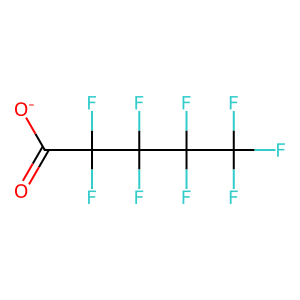

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = df['SMILES'].iloc[0]
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol, size=(300, 300))

# Visualize atom graph with networkx

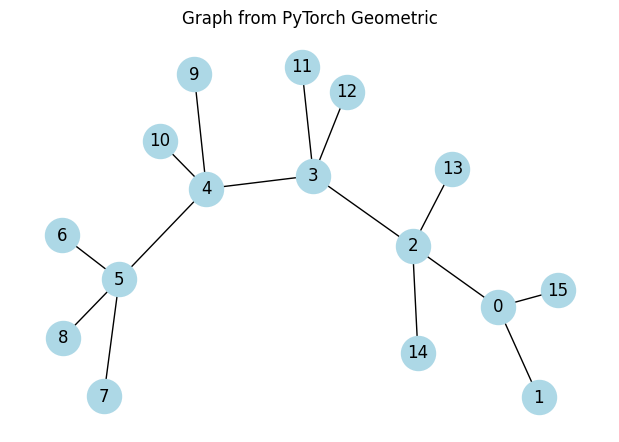

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Example: visualize first graph from graph_list
data = graph_list[0]
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=600)
plt.title("Graph from PyTorch Geometric")
plt.show()

# Label Nodes with Atom Types

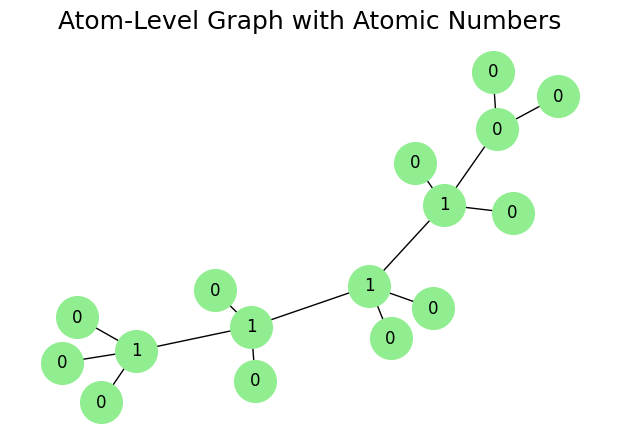

In [ ]:
labels = {i: int(data.x[i][1].item()) for i in range(data.num_nodes)}

plt.figure(figsize=(6, 4))
nx.draw(G, labels=labels, with_labels=True, node_color='lightgreen', node_size=900)
plt.title("Atom-Level Graph with Atomic Numbers", fontsize=18)
plt.show()

In [ ]:
graph20 = graph_list[19]
print(graph20.x)

tensor([[-1.1645,  1.4648,  0.1857,  0.2674,  0.0000, -1.1051,  0.0000, -0.3338,
          1.4388],
        [-1.1645,  1.4648,  0.1857,  0.2674,  0.0000, -1.1051,  0.0000, -0.3338,
          1.4388],
        [-1.1645,  1.4648,  0.1857,  0.2674,  0.0000, -1.1051,  0.0000, -0.3338,
          1.4388],
        [-1.1645,  1.4648,  0.1857,  0.2674,  0.0000, -1.1051,  0.0000, -0.3338,
          1.4388],
        [-1.1645,  1.4648,  0.1857,  0.2674,  0.0000, -1.1051,  0.0000, -0.3338,
          1.4388],
        [ 0.3476, -0.6592,  0.1857,  0.2674,  0.0000,  0.8132,  0.0000, -0.3338,
         -0.5966],
        [ 0.3476, -0.6592,  0.1857,  0.2674,  0.0000,  0.8132,  0.0000, -0.3338,
         -0.5966],
        [ 3.8760,  1.4648,  0.1857,  0.2674,  0.0000, -0.4833,  0.0000, -0.3338,
         -0.5966],
        [-0.1564, -0.6592,  0.1857, -3.6103,  0.0000, -1.5003,  0.0000,  2.8927,
         -0.5966],
        [-0.1564, -0.6592,  0.1857, -3.6103,  0.0000, -1.5003,  0.0000,  2.8927,
         -0.5966],


In [ ]:
print(graph20.edge_index)

tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  4,  6,  4,  7,  7,  8,  7,  9,
          7, 10,  3, 11,  3, 12,  2, 13,  2, 14,  1, 15,  1, 16,  0, 17, 17, 18,
         18, 19, 19, 20, 19, 21, 19, 22, 18, 23, 18, 24, 17, 25, 17, 26,  0, 27,
          0, 28],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  4,  7,  4,  8,  7,  9,  7,
         10,  7, 11,  3, 12,  3, 13,  2, 14,  2, 15,  1, 16,  1, 17,  0, 18, 17,
         19, 18, 20, 19, 21, 19, 22, 19, 23, 18, 24, 18, 25, 17, 26, 17, 27,  0,
         28,  0]])


In [ ]:
print(graph20.edge_attr)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [ ]:
print(graph20.smiles)

C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C(C(C(F)(F)F)(F)F)(F)F)(F)F


# Important Libraries

In [ ]:
exp_feat_dim = len(input_vars)  # = 8
node_feat_dim = graph_list[0].x.shape[1]  # Automatically inferred

In [ ]:
# Helper function for visalization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

In [ ]:
# Custom GAT-Based Graph-Level Regressor

In [ ]:
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import global_add_pool
from torch_geometric.nn import global_mean_pool


class CustomGATRegressor(nn.Module):
    def __init__(self, config, node_feat_dim, exp_feat_dim):
        super().__init__()

        self.gat = GAT(
            num_of_layers=config['num_of_layers'],
            num_heads_per_layer=config['num_heads_per_layer'],
            num_features_per_layer=config['num_features_per_layer'],
            add_skip_connection=config['add_skip_connection'],
            bias=config['bias'],
            dropout=config['dropout'],
            log_attention_weights=True
        )

        # FIX: Use last feature size directly (no multiplication by num_heads)
        gat_output_dim = config['num_features_per_layer'][-1]  # Correct dimension calculation


        self.mlp = nn.Sequential(
         nn.Linear(gat_output_dim + exp_feat_dim, 256),
         nn.ReLU(),
         nn.BatchNorm1d(256),
         nn.Dropout(0.1),
         nn.Linear(256, 128),
         nn.ReLU(),
         nn.Linear(128, 64),
         nn.ReLU(),
         nn.Linear(64, 1)
         )

    def forward(self, data):
      x, edge_index, inp = data.x, data.edge_index, data.inp
      batch = data.batch

      node_features = self.gat((x, edge_index))[0]
      graph_repr = global_mean_pool(node_features, batch)

      attention = model.gat.gat_net[0].attention_weights

    # Use inp directly (already graph-level)
      combined = torch.cat([graph_repr, inp], dim=1)  # Both are 2D tensors now
      return self.mlp(combined).squeeze()

In [ ]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=True):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

In [ ]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """

    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=True):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()

    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

# Training Dataset

In [ ]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error

def train(model, train_loader, val_loader, test_loader, config, y_scaler=y_scaler):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = MSELoss()
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            target = batch.y.view(-1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                target = batch.y.view(-1)
                loss = loss_fn(output, target)
                val_loss += loss.item() * batch.num_graphs
                val_preds.append(output.cpu())
                val_targets.append(target.cpu())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_preds = torch.cat(val_preds).numpy().reshape(-1, 1)
        val_targets = torch.cat(val_targets).numpy().reshape(-1, 1)

        if y_scaler is not None:
          val_preds = y_scaler.inverse_transform(val_preds)
          val_targets = y_scaler.inverse_transform(val_targets)


        val_mae = mean_absolute_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)
        val_rmse = mean_squared_error(val_targets, val_preds)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, MAE = {val_mae:.4f}, RMSE = {val_rmse:.4f}, R2 = {val_r2:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                print("Early stopping triggered.")
                break

    # Testing
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            test_preds.append(output.cpu())
            test_targets.append(batch.y.view(-1).cpu())

    test_preds = torch.cat(test_preds).numpy().reshape(-1, 1)
    test_targets = torch.cat(test_targets).numpy().reshape(-1, 1)

    if y_scaler is not None:
      test_preds = y_scaler.inverse_transform(test_preds)
      test_targets = y_scaler.inverse_transform(test_targets)

    test_mae = mean_absolute_error(test_targets, test_preds)
    test_rmse = mean_squared_error(test_targets, test_preds)
    test_r2 = r2_score(test_targets, test_preds)
    print(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")


In [ ]:
gat_config = {
    "num_of_layers": 3,
    "num_heads_per_layer": [2, 2, 4],
    "num_features_per_layer": [node_feat_dim, 256, 128, 64],
    "add_skip_connection": True,
    "bias": True,
    "dropout": 0.05
}

model = CustomGATRegressor(
    config=gat_config,
    node_feat_dim=node_feat_dim,
    exp_feat_dim=exp_feat_dim
)

config = {
    "lr": 5e-4,
    "weight_decay": 1e-2,
    "num_epochs": 500,
    "patience": 50
}

train(model, train_loader, val_loader, test_loader, config, y_scaler=y_scaler)

Epoch 1: Train Loss = 0.8445, Val Loss = 0.4197, MAE = 4.0527, RMSE = 33.0112, R2 = 0.3611
Epoch 2: Train Loss = 0.6734, Val Loss = 0.4449, MAE = 4.6613, RMSE = 34.9904, R2 = 0.3228
Epoch 3: Train Loss = 0.6472, Val Loss = 0.4532, MAE = 4.7575, RMSE = 35.6426, R2 = 0.3102
Epoch 4: Train Loss = 0.6008, Val Loss = 0.4173, MAE = 4.3907, RMSE = 32.8224, R2 = 0.3648
Epoch 5: Train Loss = 0.6007, Val Loss = 0.5805, MAE = 5.0801, RMSE = 45.6612, R2 = 0.1163
Epoch 6: Train Loss = 0.5617, Val Loss = 0.4005, MAE = 4.0279, RMSE = 31.5025, R2 = 0.3903
Epoch 7: Train Loss = 0.5612, Val Loss = 0.3960, MAE = 4.0908, RMSE = 31.1437, R2 = 0.3973
Epoch 8: Train Loss = 0.5704, Val Loss = 0.3841, MAE = 3.9831, RMSE = 30.2116, R2 = 0.4153
Epoch 9: Train Loss = 0.5683, Val Loss = 0.3931, MAE = 4.2606, RMSE = 30.9188, R2 = 0.4016
Epoch 10: Train Loss = 0.5102, Val Loss = 0.3756, MAE = 3.8957, RMSE = 29.5392, R2 = 0.4283
Epoch 11: Train Loss = 0.5046, Val Loss = 0.4305, MAE = 4.1155, RMSE = 33.8588, R2 = 0.34

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_actual_vs_predicted_train_test(model, train_loader, test_loader, y_scaler):
    model.eval()
    device = next(model.parameters()).device

    def get_preds_and_targets(loader):
        preds, targets = [], []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                output = model(batch)
                preds.append(output.cpu().numpy())
                targets.append(batch.y.view(-1).cpu().numpy())
        preds = np.concatenate(preds).reshape(-1, 1)
        targets = np.concatenate(targets).reshape(-1, 1)
        return preds, targets

    # Get predictions and targets
    train_preds, train_targets = get_preds_and_targets(train_loader)
    test_preds, test_targets = get_preds_and_targets(test_loader)

    # Inverse transform if needed
    if y_scaler is not None:
        train_preds = y_scaler.inverse_transform(train_preds)
        train_targets = y_scaler.inverse_transform(train_targets)
        test_preds = y_scaler.inverse_transform(test_preds)
        test_targets = y_scaler.inverse_transform(test_targets)

    # Compute metrics
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds)
    test_mae = mean_absolute_error(test_targets, test_preds)
    test_rmse = mean_squared_error(test_targets, test_preds)

    # Print metrics
    print(f"Train MAE:  {train_mae:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test MAE:   {test_mae:.4f}, RMSE: {test_rmse:.4f}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(train_targets, train_preds, color='blue', edgecolor='k', alpha=0.6,
                label=f'Train (MAE={train_mae:.2f}, RMSE={train_rmse:.2f})')
    plt.scatter(test_targets, test_preds, color='green', edgecolor='k', alpha=0.7,
                label=f'Test (MAE={test_mae:.2f}, RMSE={test_rmse:.2f})')

    min_val = min(train_targets.min(), test_targets.min())
    max_val = max(train_targets.max(), test_targets.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

    # Set larger font sizes
    plt.xlabel("Actual Removal Rate", fontsize=18)
    plt.ylabel("Predicted Removal Rate", fontsize=18)
    #plt.title("Actual vs. Predicted PFAS Removal Rate (Train & Test)", fontsize=16)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


Train MAE:  2.5114, RMSE: 17.2093
Test MAE:   3.1693, RMSE: 25.9930


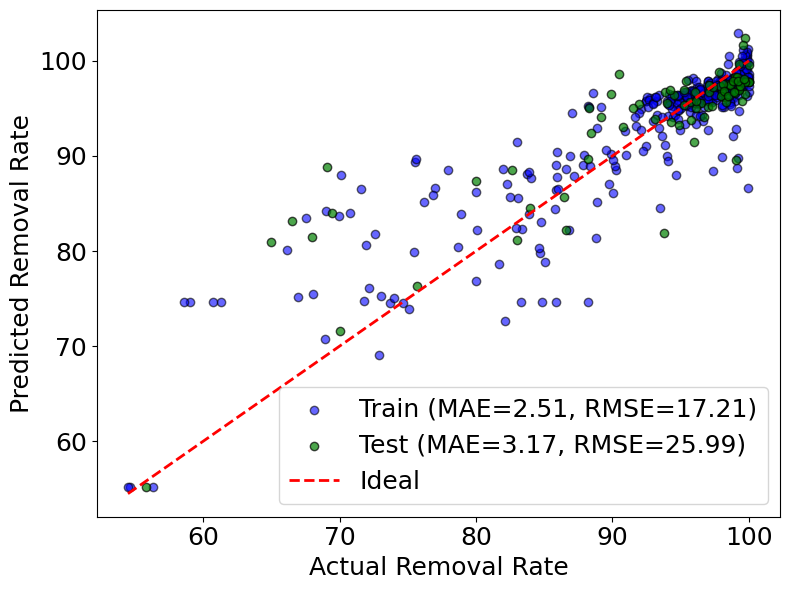

In [ ]:
plot_actual_vs_predicted_train_test(model, train_loader, test_loader, y_scaler)